<div class="alert alert-info" role="alert">
  <hr> <center> <font size="+3.5"> <b> Interpréter des conditions atypiques à l'aide d'autoencodeurs variationnels conditionnels </b> </font> </center> <hr>
</div>

<div class="alert alert-block" role="alert">
    <center><b> <u>Auteur :</u>  Clement GOUBET  </b></center>
</div>
<div class="alert alert-block" role="alert">
    <center> <font size="+1.5"> <b>  23 octobre 2019  </b>  </font> </center>
</div>

# Table de contenu

## 0. Préparation de l'environnement de travail
- chargement des modules
- mise en forme des données
- définition de quelques fonctions utiles

## 1. Modèle de stacking d'encodeurs
- construction du modèle
- entrainement
- évaluation de la représentation obtenue


## 2. Modèle avec prior mixture
- construction du modèle
- entrainement
- évaluation de la représentation obtenue

## 3. Modèle LEAP
- construction du modèle
- entrainement
- évaluation de la représentation obtenue

## 4. Modèle Guidé
- construction du modèle
- entrainement
- évaluation de la représentation obtenue

<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 0. Preparation de l'environnement de travail </b> </font> <hr>
</div>

# Chargement des modules et mise en forme des données

In [1]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
import seaborn as sn
from scipy import stats
import cv2 #from open-cv, to convert array to images
from IPython.display import Image
from keras.callbacks import TensorBoard
from time import time
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
#paths in git

#root git folder 
path_main_folder = '/home/goubetcle/Documents/CVAE/marota_cvae'
#path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_main_folder)
#add  to path source code folder
sys.path.append(path_main_folder+'/src')

In [3]:
#import class and methods from src
from keras import backend as K
from CVAE.callbacks import *
#from CVAE.cvae import compile_cvae, run_cvae
from conso.load_shape_data import *

import Visualisation.buildProjector
from Visualisation.buildProjector import *
from FeaturesScore.scoring import *
from FeaturesScore.exploration import *

#from conso.load_shape_data import get_x_conso_autoencoder
from conso.conso_helpers import plot_latent_space_projection, pyplot_latent_space_projection_temp, pyplot_latent_space_projection_error


In [4]:
import CVAE.cvae_model
import CVAE.cvae_model_mixture
import CVAE.cvae_model_cluster
import importlib
importlib.reload(CVAE.cvae_model)
importlib.reload(CVAE.cvae_model_mixture)
importlib.reload(CVAE.cvae_model_cluster)
%load_ext autoreload
%autoreload

Instructions for updating:
Colocations handled automatically by placer.


Les données de consommation et de température sont des prises de mesure par pas de temps 30 minutes pendant 5 années de décembre 2012 à décembre 2017. 

In [5]:
# Load dataframe
path_data = os.path.join(path_main_folder, 'data')
dataset_csv = os.path.join(path_data, "dataset.csv")
x_conso = pd.read_csv(dataset_csv, sep=",",)
x_conso.ds = pd.to_datetime(x_conso.ds)

#drop indices column
x_conso=x_conso.drop(columns=x_conso.columns[0],axis=1)

#Visualize data frame head
x_conso.tail(5)

ds  consumption_France  temperature_France  \
87825 2017-12-31 21:30:00             56505.0            9.306475   
87826 2017-12-31 22:00:00             56000.0            9.097250   
87827 2017-12-31 22:30:00             56995.0            9.048775   
87828 2017-12-31 23:00:00             60395.0            9.000300   
87829 2017-12-31 23:30:00             60230.0            9.000300   

       is_holiday_day  
87825             0.0  
87826             0.0  
87827             0.0  
87828             0.0  
87829             0.0

On s'intéresse ici à caractériser les profils journaliers. L'ensemble de données est donc transformé pour que notre jeu d'entrée soit ait en colonnes les points de mesure journaliers de la consommation d'électricité. Avant cela, il est ici normalisé sur l'ensemble des mesures.

In [6]:
name_set_plot = 'train'
version = '-v1'
nPoints=1830

dict_xconso = {'train': x_conso}

# Normalize input variables
type_scaler = 's'
dict_xconso, _ = normalize_xconso(dict_xconso, type_scaler = 'standard')

['consumption_France']


In [28]:
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso)
dataset_temp, to_emb_dim = get_dataset_autoencoder(dict_xconso=dict_xconso, list_cond=['temperature'],embedding=True)

temperature (1830, 48)
2


Le dictionnaire dataset contient toutes les informations nécessaires à l'entrainement des modèles :
- dataset['train']['x'] contient la liste des entrées de l'encodeur:
-- [0] les profils de consommations
-- [1] les conditions passées en entrée de l'encodeur et du décodeur pour rendre la représentation latente plus indépendante de ces variables
- dataset['train']['y'] contient une copie des profils des consommation (pointeur pour le calcul des pertes de reconstruction dans l'apprentissage des modèles)
- dataset['train']['ds'] contient les dates des exemples

Pour interpréter notre représentation, on peut chercher à visualiser des paramètres connus associés à nos profils journaliers. Ici il s'agit notamment de données calendaires (mois, weekend, jour férié), auxquels on peut rajouter la température moyenne observée sur la journée (par exemple), ou encore la pente moyenne du profil.

Ces informations sont à passer dans calendar_info pour être visualisés dans une projection Tensorboard, et à passer en type et en valeur respectivement dans le dictionnaire factorDesc et factorMatrix pour servir dans l'évaluation des latents. 

In [150]:
#importation des données calendaires
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, x_conso[['ds', 'is_holiday_day']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_holiday_day'].isna(),'is_holiday_day'] = 0
calendar_info['year'] = calendar_info.ds.dt.year

calendar_info['season'] = np.ones_like(calendar_info['month'].values) *3
calendar_info['season'].iloc[np.where((calendar_info.ds.dt.month == 10) + (calendar_info.ds.dt.month == 4) + ((calendar_info.ds.dt.month == 5) * (calendar_info.ds.dt.day <= 25)))] = 2
calendar_info['season'].iloc[np.where((calendar_info.ds.dt.month <= 3) + (calendar_info.ds.dt.month >= 11))] = 1                        
                                    

In [151]:
calendar_info

ds  month  weekday  is_weekday  is_holiday_day  year  season
0    2012-12-28     12        4           1             0.0  2012       1
1    2012-12-29     12        5           0             0.0  2012       1
2    2012-12-30     12        6           0             0.0  2012       1
3    2012-12-31     12        0           1             0.0  2012       1
4    2013-01-01      1        1           1             1.0  2013       1
5    2013-01-02      1        2           1             0.0  2013       1
6    2013-01-03      1        3           1             0.0  2013       1
7    2013-01-04      1        4           1             0.0  2013       1
8    2013-01-05      1        5           0             0.0  2013       1
9    2013-01-06      1        6           0             0.0  2013       1
10   2013-01-07      1        0           1             0.0  2013       1
11   2013-01-08      1        1           1             0.0  2013       1
12   2013-01-09      1        2           1             0.0  2013       1
13   2013-01-10      1        3           1             0.0  2013       1
14   2013-01-11      1        4           1             0.0  2013       1
15   2013-01-12      1        5           0             0.0  2013       1
16   2013-01-13      1        6           0             0.0  2013       1
17   2013-01-14      1        0           1             0.0  2013       1
18   2013-01-15      1        1           1             0.0  2013       1
19   2013-01-16      1        2           1             0.0  2013       1
20   2013-01-17      1        3           1             0.0  2013       1
21   2013-01-18      1        4           1             0.0  2013       1
22   2013-01-19      1        5           0             0.0  2013       1
23   2013-01-20      1        6           0             0.0  2013       1
24   2013-01-21      1        0           1             0.0  2013       1
25   2013-01-22      1        1           1             0.0  2013       1
26   2013-01-23      1        2           1             0.0  2013       1
27   2013-01-24      1        3           1             0.0  2013       1
28   2013-01-25      1        4           1             0.0  2013       1
29   2013-01-26      1        5           0             0.0  2013       1
...         ...    ...      ...         ...             ...   ...     ...
1800 2017-12-02     12        5           0             0.0  2017       1
1801 2017-12-03     12        6           0             0.0  2017       1
1802 2017-12-04     12        0           1             0.0  2017       1
1803 2017-12-05     12        1           1             0.0  2017       1
1804 2017-12-06     12        2           1             0.0  2017       1
1805 2017-12-07     12        3           1             0.0  2017       1
1806 2017-12-08     12        4           1             0.0  2017       1
1807 2017-12-09     12        5           0             0.0  2017       1
1808 2017-12-10     12        6           0             0.0  2017       1
1809 2017-12-11     12        0           1             0.0  2017       1
1810 2017-12-12     12        1           1             0.0  2017       1
1811 2017-12-13     12        2           1             0.0  2017       1
1812 2017-12-14     12        3           1             0.0  2017       1
1813 2017-12-15     12        4           1             0.0  2017       1
1814 2017-12-16     12        5           0             0.0  2017       1
1815 2017-12-17     12        6           0             0.0  2017       1
1816 2017-12-18     12        0           1             0.0  2017       1
1817 2017-12-19     12        1           1             0.0  2017       1
1818 2017-12-20     12        2           1             0.0  2017       1
1819 2017-12-21     12        3           1             0.0  2017       1
1820 2017-12-22     12        4           1             0.0  2017       1
1821 2017-12-23     12        5           0             0.0  2017       1
1822 2017-12-24  

In [10]:
#importation des données météo
meteo1_csv = os.path.join(path_data, "meteo_events.csv")
meteo2_csv = os.path.join(path_data, "meteo_events_2.csv")

meteo_events1 = pd.read_csv(meteo1_csv)
meteo_events2 = pd.read_csv(meteo2_csv)
meteo_events = meteo_events1.append(meteo_events2)
events = ['snow', 'floods', 'storm', 'hurricane', 'heavy_rains', 'cold', 'hot']
meteo_records=pd.DataFrame(data=np.zeros((nPoints, len(events))), columns=events)
from datetime import *
for k in range(meteo_events.shape[0]):
    day = datetime.strptime(meteo_events.iloc[k,0],'%Y-%m-%d')
    cld = np.asarray(calendar_info.ds.dt.date)
    row = np.where(cld==day.date())[0]
    meteo_records.iloc[row,:]+=np.asarray(meteo_events.iloc[k,2:-1])
    duration = int(meteo_events.iloc[k,1])
    if duration != 0:
        for i in range(duration):
            day_inc = timedelta(days=i+1)+day
            cld = np.asarray(calendar_info.ds.dt.date)
            row = np.where(cld==day_inc.date())[0]
            meteo_records.iloc[row,:]+=np.asarray(meteo_events.iloc[k,2:-1])

meteo_records.iloc[:,:] = 1*(meteo_records.iloc[:,:]>0)

In [11]:
meteo_records.describe()

snow       floods        storm    hurricane  heavy_rains  \
count  1830.000000  1830.000000  1830.000000  1830.000000  1830.000000   
mean      0.092350     0.077049     0.087432     0.068852     0.087432   
std       0.289598     0.266742     0.282544     0.253272     0.282544   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

              cold          hot  
count  1830.000000  1830.000000  
mean      0.074863     0.157377  
std       0.263243     0.364255  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     0.000000  
75%       0.000000     0.000000  
max       1.000000     1.000000

In [12]:
#Study conso variations as importance factors
slope = np.abs(np.diff(dataset['train']['x'][0]))
#variationMax = np.max(slope, axis=1)
variationMean = np.mean(slope, axis = 1)
#calendar_info['load_variation_max'] = variationMax
calendar_info['load_variation_mean'] = variationMean

In [13]:
#explicit the potential bridge days taken as extended holidays
day_hol = calendar_info[['weekday', 'is_holiday_day']].copy().values
bridge_index=[]
for i in range(day_hol.shape[0]):
    if day_hol[i,1]==1:
        if day_hol[i,0]==1:
            bridge_index.append(i-1)
        elif day_hol[i,0]==3:
            bridge_index.append(i+1)

bridges = np.zeros(day_hol.shape[0])
bridges[np.asarray(bridge_index)] = 1

calendar_info['potential_bridge_holiday'] = bridges
#calendar_info['potential_bridge_holiday'].describe()

In [14]:
factors = calendar_info.iloc[:,1:5].copy()
columns_x = x_conso.columns
conso_idx = np.argmax(['consumption' in c for c in x_conso.columns])
temp_idx = np.argmax(['temperature' in c for c in x_conso.columns])
dates = np.unique(x_conso['ds'].dt.date)
temperatureMean=np.asarray([np.mean(x_conso[columns_x[temp_idx]].iloc[np.where(x_conso['ds'].dt.date==dates[k])]) for k in range(dates.shape[0])])

factorMatrix = np.c_[factors.values,temperatureMean]

factorDesc={
    'month':'category',
    'weekday':'category',
    'is_weekday':'category',
    'is_holiday_day':'category',
    'temperature':'regressor'
}

In [15]:
meteo_records

snow  floods  storm  hurricane  heavy_rains  cold  hot
0        0       0      0          0            0     0    0
1        0       0      0          0            0     0    0
2        0       0      0          0            0     0    0
3        0       0      0          0            0     0    0
4        0       0      0          0            0     0    0
5        0       0      0          0            0     0    0
6        0       0      0          0            0     0    0
7        0       0      0          0            0     0    0
8        0       0      0          0            0     0    0
9        0       0      0          0            0     0    0
10       0       0      0          0            0     0    0
11       0       0      0          0            0     0    0
12       0       0      0          0            0     0    0
13       0       0      0          0            0     0    0
14       0       0      0          0            0     0    0
15       0       0      0          0            0     0    0
16       1       1      0          0            1     1    0
17       1       1      0          0            1     1    0
18       1       1      0          0            1     1    0
19       1       1      0          0            1     1    0
20       1       1      0          0            1     1    0
21       1       1      0          0            1     1    0
22       1       1      0          0            1     1    0
23       1       1      0          0            1     1    0
24       1       1      0          0            1     1    0
25       1       1      0          0            1     1    0
26       1       1      0          0            1     1    0
27       1       1      0          0            1     1    0
28       1       1      0          0            1     1    0
29       1       1      0          0            1     1    0
...    ...     ...    ...        ...          ...   ...  ...
1800     1       0      0          0            0     1    0
1801     1       0      0          0            0     1    0
1802     1       0      0          0            0     1    0
1803     0       0      0          0            0     0    0
1804     0       0      0          0            0     0    0
1805     0       0      0          0            0     0    0
1806     0       0      0          0            0     0    0
1807     0       0      0          0            0     0    0
1808     1       0      0          1            0     0    0
1809     1       0      0          1            0     0    0
1810     1       0      0          1            0     0    0
1811     0       0      0          0            0     0    0
1812     0       0      0          0            0     0    0
1813     0       0      0          0            0     0    0
1814     0       0      0          0            0     0    0
1815     0       0      0          0            0     0    0
1816     0       0      0          0            0     0    0
1817     0       0      0          0            0     0    0
1818     0       0      0          0            0     0    0
1819     0       0      0          0            0     0    0
1820     0       0      0          0            0     0    0
1821     0       0      0          0            0     0    0
1822     0       0      0          0            0     0    0
1823     0       0      0          0            0     0    0
1824     0       0      0          0            0     0    0
1825     0       0      0          0            0     0    0
1826     0       0      0          0            0     0    0
1827     0       0      0          0            0     0    0
1828     0       0      0          0            0     0    0
1829     0       0      0          1            0     0    0

[1830 rows x 7 columns]

# Tools to evaluate the representations

In [42]:
#visualisation des metriques
def display_metrics(model_eval, z_dim, factorDesc):
    if 'reconstruction_error' in model_eval.keys():
        for k,v in model_eval['reconstruction_error'].item():
            print(k, ' : ', v)
    print('Mutual Information Gap : %.2f'%model_eval['mig'])

    fig = plt.figure(dpi=100,figsize=(10,8))

    plt.subplot(2, 3, 1)
    fig.subplots_adjust(hspace=0.5)
    plt.bar(factorDesc.keys(),model_eval['informativeness'])
    plt.xlabel('factors')
    plt.xticks(rotation=75)
    plt.ylim(top=1)
    for index,data in enumerate(model_eval['informativeness']):
        plt.text(x=index - 0.5, y =data+0.01 , s="%.2f"%data , fontdict=dict(fontsize=10))
    plt.title('Informativeness score : %.2f'%np.mean(model_eval['informativeness']))

    plt.subplot(2, 3, 2)
    plt.bar(np.arange(z_dim)+1,np.log(6)*model_eval['disentanglement'])
    plt.xlabel('latent variables')
    plt.title('Disentanglement score : %.2f'%model_eval['mean_disentanglement']);

    plt.subplot(2, 3, 3)
    plt.bar(factorDesc.keys(),model_eval['compactness'])
    plt.xlabel('factors')
    plt.xticks(rotation=75)
    plt.title('Compactness')
    plt.tight_layout();
    
#    plt.subplot(2, 3, 5)
 #   plt.bar(np.arange(z_dim)+1,1-model_eval['modularity'])
  #  plt.xlabel('latent variables')
   # plt.title('Modularity score : %.2f'%np.mean(1-model_eval['modularity']));

In [17]:
from math import cos, sin
#visualisation d'une représentation 2D dans le notebook
def prez_2D(x_encoded):
    proj2D = PCA(2)
    proj = proj2D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,0], marker = 'o', s=500, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');
    
def prez_3D(x_encoded):
    proj3D = PCA(3)
    proj_z = proj3D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    proj = proj_z[:,:2]
    third = proj_z[:,2]
    
    proj = proj + np.tile(third.reshape(-1,1), (1,2)) * np.tile(np.array([[-cos(0.785),sin(0.785)]]),(nPoints,1))
    
    size = 300  + (1.- np.exp(-third / max(third))) * 800
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,0], marker = 'o', s=size, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');

Pour créer une représentation sous tensorboard, la fonction suivante regroupe toutes les étapes. Le booléen includeConsuptionProfileImages active ou non le marqueur des points à l'image des profils de consommation.

In [18]:
def tensorboardProjection(name_model,x, x_hat, x_encoded, x_conso, calendar_info, log_dir_projector, includeConsumptionProfileImages=True):
    #can take a bit longer to create and load in tensorboard projector, but it looks better in the projector
    if includeConsumptionProfileImages:
        nPoints=1500 #if you want to visualize images of consumption profiles and its recontruction in tensorboard, there is a maximum size that can be handle for a sprite image. 1830 is  
        x_encoded_reduced=x_encoded[0:nPoints,]
        images=createLoadProfileImages(x,x_hat,nPoints)
    else:
        nPoints=1830
        
    if includeConsumptionProfileImages:
        sprites=images_to_sprite(images)
        cv2.imwrite(os.path.join(log_dir_projector, 'sprite_4_classes.png'), sprites)
    
    writeMetaData(log_dir_projector,x_conso,calendar_info,nPoints,has_Odd=False)
    if includeConsumptionProfileImages:
        buildProjector(x_encoded_reduced,images=images, log_dir=log_dir_projector)
    else:
        buildProjector(x_encoded,images=None, log_dir=log_dir_projector)
        
    print(log_dir_projector)

In [19]:
#Visualisation des courbes de charge en entrée et reconstruite par le modèle
mean_sc, var_sc = stats.describe(x_conso.consumption_France)[2:4]
std_sc = np.sqrt(var_sc)
def display_loads(x, x_hat,date,mae):
    fig = plt.figure(dpi=100,figsize=(5,5))
    #set(gca,'Color','k')
    plt.plot(x*std_sc+ mean_sc, label = 'truth')
    plt.plot(x_hat*std_sc+ mean_sc, '--', label = 'reconstruction')
    plt.title(date+' - mean absolute error %0.2f GW' %(mae*std_sc/1000))
    plt.xlabel('hours')
    plt.ylabel('load (MW)')
    plt.xlim((0,48))
    plt.xticks([5,11,17,23,29,35,41], [3,6,9,12,15,18,21])
    plt.legend(loc='lower right')
    plt.grid();

<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 1. Un modèle modes </b> </font> <hr>
</div>

## Rappels

Les autoencodeurs variationnels sont des modèles qui fonctionnent en duo:
- un encodeur qui traduit les données d'entrée dans un espace latent de dimension arbitrairement choisie. Plus exactement il cherche les paramètres de distribution des variables latentes dans chacune des dimensions.
- un decodeur qui cherche à reconstruire les entrées à partir des coordonnées dans l'espace latent

Pendant l'appentissage, le lien entre encodeur et decodeur est réalisé par l'échantillage selon les paramètres de distribution appris : chaque échantillon a des coordonnées latentes tirées aléatoirement selon cette dernière, que le décodeur cherche à retraduire dans l'espace de dimension initial. 


Il s'agit dans un premier temps de paramétrer les dimensions des couches de nos réseaux de neurone:
- celles de l'encodeur e_dim
- celles du décodeur d_dims
- les dimensions de notre espace latent z_dim (chaque paramètre de distribution sera donc aussi de dimension z_dim)

## Construire et entrainer un modèle Modes-VAE

Le nombre d'encodeur passe de 1 à N, dont les sorties sont toujours les paramètres d'une distribution. Le nombre N de modes est déterminé par la distribution a priori du mélange prior\_mixture (par défaut loi uniforme).

Je laisse la possibilité de choisir une moyenne $\mu$ identique dans chacune des dimensions latentes mais différente par modes avec le paramètre prior\_mu.

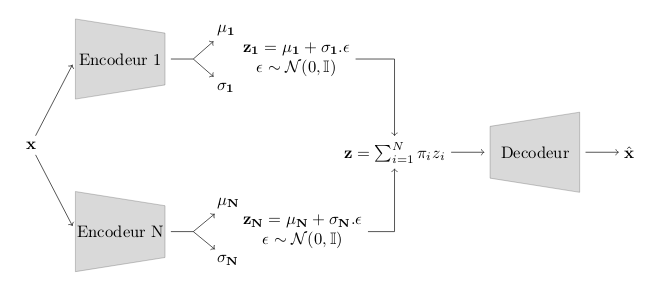

In [170]:
Image(path_main_folder+'/images/modes_vae.png', width=666)

In [173]:
# paramètres de l'autoencodeur qui sera répété pour chaque encodeur
z_dim = 4 # le nombre de dimensions voulues dans notre représentation latente
e_dims=[48,35,24,12]# les couches cachées du bloc encodeur; premier nombre = inputs_dim
d_dims=[48,96,35,12]# les couches cachées du bloc decodeur; premier nombre = outputs_dim
lr=3e-4 # le learning rate de l'optimiseur
input_dim = dataset['train']['x'][0].shape[1]

Pour les paramètres liés au modèle, il faut rappeler le fonctionnement du VAE. On cherche la maximisation de la borne inférieure de la log-vraissemblance du modèle reconstruit ou ELBO qui se décompose en deux termes :

ELBO $= \mathbb{E}_{q_\phi(z|x)} \log(p_\theta(x|z)) - KL(q_\phi(z|x) \| p(z))$

Dans notre objectif d'apprentissage, cela est traduit par une perte à minimiser de la forme:

Obj $= \|x - \hat{x}\| +  KL(q_\phi(z|x) \| p(z))$.

- L'erreur de reconstruction peut être choisie selon une mesure en norme L1 ou L2. La norme L1 permet notamment d'obtenir des profils avec moins de valeurs abérrantes.

- Un prior $p(z)$ laplacien plutôt que gaussien permet des concentrations plus piquées des groupements similaires, et renvoie plus loin les points atypiques. 

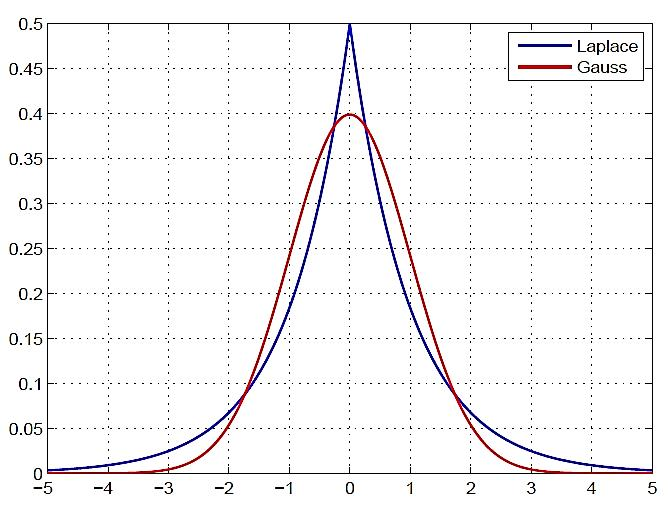

In [22]:
Image(path_main_folder+'/images/lois_laplace_normale.jpg', width=500)


- Par ailleurs, pour faciliter l'apprentissage du modèle de façon structurée dans les dimensions choisies de l'espace latent, l'action peut se porter sur le choix du prior comme sur des critères de régularisation devant le terme de divergence.

    Ces termes de régularisation s'appliquent de la façon suivante :

    Obj $= \|x - \hat{x}\| +  \beta KL(q_\phi(z|x) \| p(z)) + \gamma MMD(q_\phi(z) \| p(z))$ si modèle InfoVAE
    avec $\beta \in \left[0,1\right] $ et $\gamma \ge 0$ (si possible grand)

In [24]:
# paramètres du modèle variationnel choisi

## pour l'erreur de reconstruction (entre L1 et L2)
is_L2_Loss=False

## pour le choix du modèle de distribution a priori et a posteriori entre 'Gaussian' et 'Laplace':
pdf_model = 'Gaussian'

## pour la régularisation de la fonction objectif : VAE classique --> beta = 1 et gamma = 0
Beta = K.variable(0.33, dtype='float32') 

InfoVAE = True #pour activer la régularisation supplémentaire InfoVAE
Gamma = K.variable(66., dtype='float32')

#forme de la matrice covariance diagonale du prior
sigma_prior = K.variable(np.array([64,10,1,0.1]),dtype='float32')

In [31]:
# paramètres de l'entrainement du modèle
epochs = 800
batch_size = 16

emb_dims= [[48,12]]
emb_to_z_dim = [12,z_dim]

In [37]:
# création du modèle
name_model = 'cvae_modes'
log_dir_projector=path_main_folder+"/notebooks/logs/Usecase/"+name_model+"/projector" #pour créer le dossier du projeteur tensorboard
log_dir_model=path_main_folder+"/notebooks/logs/Usecase/"+name_model+"/model" #pour créer le dossier de sauvegarde du modèle
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model

model_cvae_mode = CVAE.cvae_model_mixture.CVAE_emb(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_pre_dim=0, InfoVAE=True,
                                beta=Beta, gamma = Gamma,  is_L2_Loss=is_L2_Loss,
                                 pdf_model=pdf_model, prior_mu = np.zeros(5), #prior mu doit être 1D, valeur par mode.
                                 to_emb_dim = to_emb_dim, emb_dims=emb_dims, emb_to_z_dim=emb_to_z_dim,
                                name=name_model, output=path_out)

4
L1 loss
False
L1 loss
False
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
emb_input_0 (InputLayer)        (None, 48)           0                                            
__________________________________________________________________________________________________
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
embedding_enc (Model)           (None, 4)            3212        emb_input_0[0][0]                
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 34827       x_true[0][0]                     
                                                

In [33]:
tensorboard = TensorBoard(log_dir="logs/Usecase/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)

"""""si besoin d'un callback qui fasse décroitre \beta
lambda_decreaseRate=0.0015 #parameter by default 
lambda_min = 0.05 
lambda_val=1
start = 400
weightLoss=callbackWeightLoss(lambda_val,lambda_decreaseRate,lambda_min,start)
"""""

'""si besoin d\'un callback qui fasse décroitre \x08eta\nlambda_decreaseRate=0.0015 #parameter by default \nlambda_min = 0.05 \nlambda_val=1\nstart = 400\nweightLoss=callbackWeightLoss(lambda_val,lambda_decreaseRate,lambda_min,start)\n'



--- START TRAINING ---

Instructions for updating:
Use tf.cast instead.


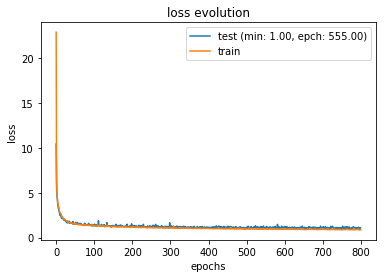

In [38]:
#apprentissage du modèle
 #use verbose=1 to see logs of training at every epoch
runTraining = False
if runTraining:
    model_cvae_mode.main_train(dataset_temp, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard],validation_split=0.2)

## Evaluer le modèle

In [66]:
#charger le modèle déjà entrainé si besoin
load_model=1-runTraining
if load_model:
    model_cvae_mode.load_model(os.path.join(path_out, name_model, 'models'))

In [39]:
# Récupération de la représentation latente via les distributions a posteriori des profils
x_input = dataset_temp['train']['x']
emb_inputs=x_input[1:]
emb_outputs = model_cvae_mode.embedding_enc.predict(emb_inputs)
input_encoder = [dataset_temp['train']['x'][0], emb_outputs]
x_encoded = model_cvae_mode.encoder.predict(input_encoder)[0]


### Rappels sur les métriques

- Le score d'informativité mesure à quel point des informations préalablements identifiées se retrouvent effectivement dans la représentation latente (erreur de prediction des facteurs K avec l'espace latent);


- Le score de démélement quantifie à quel point les axes latents sont partagés par un ou plusieur facteurs d'importance;

    ==> Calcul : Par dimension i de l'espace latent, $D_i = 1 - H_K(P_i)$ qui représente l'entropie du fait que l'axe soit important pour prédire les facteurs K


- Le score de compacité qui quantifie si un facteur d'importance arrive à aligner les points selon un axe;

    ==> Calcul : Par facteur k de l'espace latent, $D_k = 1 - H_i(P_k)$ qui représente l'entropie de la distribution de $P_k$ le long des axes.


- Le score de Mutual Information Gap, qui quantifie à la fois la reprise d'information dans les axes latents et l'indépendance mutuelle entre ces derniers.

    ==> Calcul : $\frac{1}{k} \sum_k \max_{i,j\in\text{z_dim}} (I(i,k) - I(j,k))$ où I est l'information mutuelle.


Sources :

1) A Framework for the Quantitative Evaluation of Disentangled Representations (C. Eastwood and C. K. I. Williams, ICLR 2018)

2) Isolating Sources of Disentanglement in VAEs (Chen et al., 2018)

Mutual Information Gap : 0.13


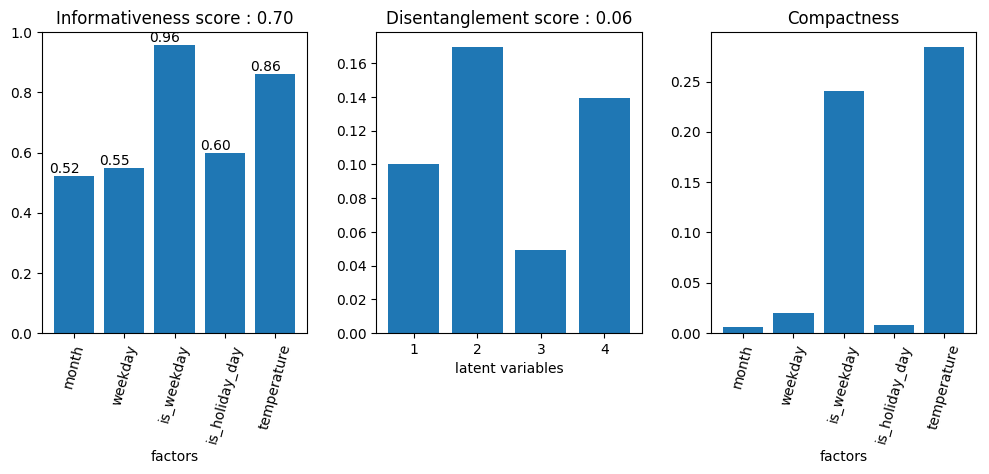

In [43]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc, orthogonalize=True)
display_metrics(model_eval, z_dim, factorDesc)

Il faut savoir que le modèle "modes" ne permet pas de bien conditionner

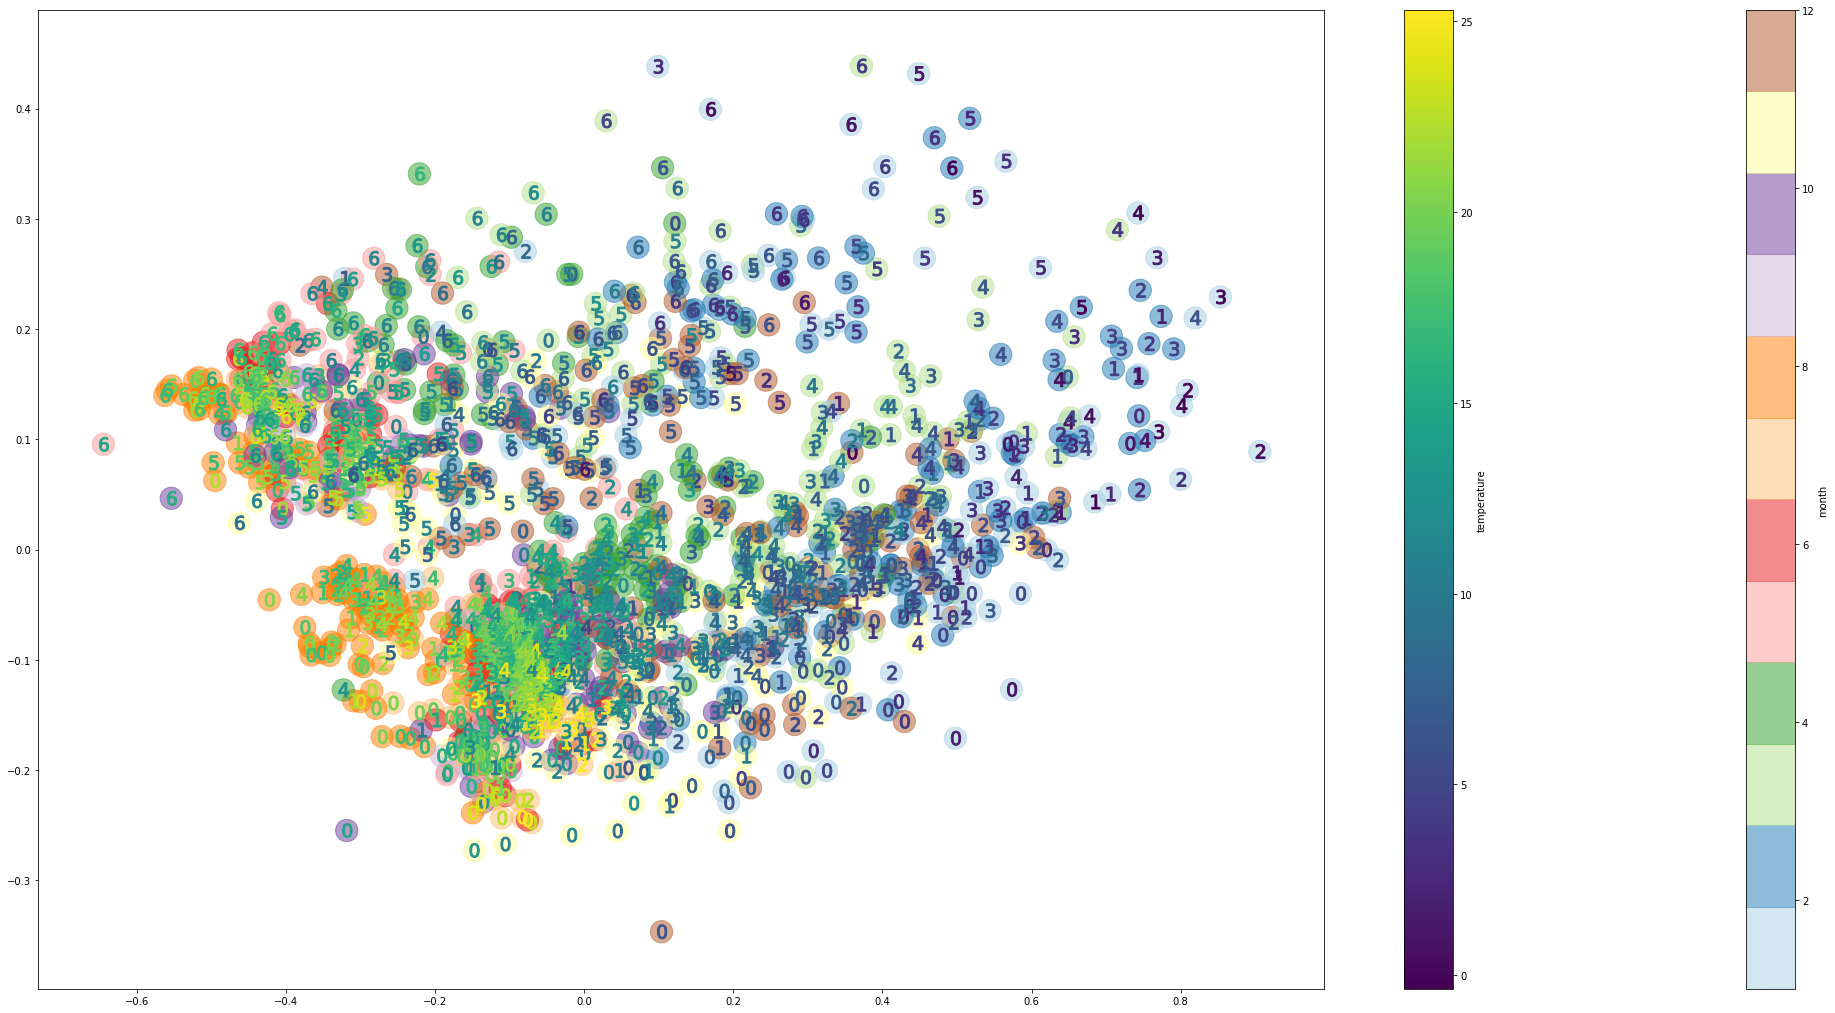

In [41]:
prez_2D(x_encoded)

In [77]:
#calculer l'erreur de reconstruction
x = input_encoder[0]
x_hat =  model_vae.cvae.predict(input_encoder)[0]
mae_error = np.sum(np.abs((x - x_hat)),axis=1)
mse_error = np.sqrt(np.sum((x - x_hat)**2, axis=1)) 

print(np.mean(mae_error),np.std(mae_error))
print(np.mean(mse_error),np.std(mse_error))

1.9528068871346673 0.8882754671168388
0.36267306568133123 0.17041069095543018


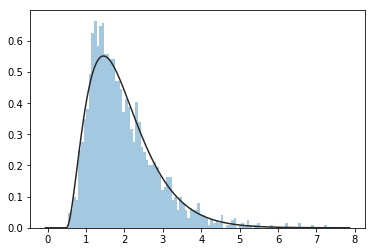

In [78]:
import seaborn as sn
sn.distplot(mae_error, kde=False, fit=stats.gamma, bins=100);

## Construction de la représentation explorable avec Tensorboard

all_info = calendar_info.join(meteo_records)
tensorProj = True
if tensorProj:
    tensorboardProjection(name_model,x,x_hat, x_encoded, x_conso, all_info, log_dir_projector, includeConsumptionProfileImages=True)

<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 2. Modèle avec prior mixture </b> </font> <hr>
</div>




$$p(z) = \sum_{i=1}^K \pi_i\mathcal{N}(\mu_i,\sigma_i)\text{ \& }q(z|x) \sim \mathcal{N}(\mu,\sigma).$$

Avec un prior sous forme de mélaange gaussien, la sortie de l'encodeur ne change pas. Seule change la formulation de la divergence KL, à qui est donnée une nouvelle borne supérieure. En effet, si f et g sont des mélanges gaussiens avec le même nombre de composants:

$$D(f\|g) \le \sum_a \pi_a \left(D_{KL}(f_a\|g_a) + \log \frac{\pi_a}{\omega_a} \right).$$

Ici, la sortie de l'encodeur est donc découpée selon la distribution du mélange du prior pour avoir le même nombre de composantes. J'aurais peut être du faire un softmax, voir le modèle cluster pour rajouter cette partie si plus pertinent). 

In [93]:
# paramètres de l'entrainement du modèle
epochs = 800
batch_size = 16
prior_mu = np.array([[-10,0,10],  #ici c'est la moyenne a priori du mélange gaussien, 
                    [0,0,0],      #avec une ligne par dimension, une colonne par composante.
                     [-10,10,-10],
                     [0,0,0]])
prior_mixture=np.array([0.5,0.4,0.1]) #Distribution a priori du mélange
Beta = K.variable(0.4, dtype='float32')
Gamma = K.variable(66, dtype='float32') #nécessaire pour forcer la mixture

In [101]:
# création du modèle
name_model = 'cvae_mixture'
log_dir_projector=path_main_folder+"/notebooks/logs/Usecase/"+name_model+"/projector" #pour créer le dossier du projeteur tensorboard
log_dir_model=path_main_folder+"/notebooks/logs/Usecase/"+name_model+"/model" #pour créer le dossier de sauvegarde du modèle
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model

model_mixture = CVAE.cvae_model_cluster.CVAE_mixture(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_dim=1, InfoVAE = True,
                                beta=Beta, gamma = Gamma,  is_L2_Loss=False,
                                prior_mu=K.variable(prior_mu,dtype='float32'),prior_mixture=K.variable(prior_mixture, dtype='float32'),
                                name=name_model, output=path_out)

InfoVAE :  True
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 5454        x_true[0][0]                     
                                                                 cond_pre[0][0]                   
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 4)            0        

In [102]:
tensorboard = TensorBoard(log_dir="logs/Usecase/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)



--- START TRAINING ---



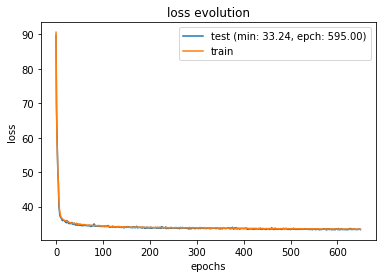

In [103]:
#apprentissage du modèle
 #use verbose=1 to see logs of training at every epoch
runTraining = True
if runTraining:
    model_mixture.main_train(dataset, training_epochs=epochs-150, batch_size=batch_size, verbose=0,callbacks=[],validation_split=0.1)
else:
    model_mixture.load_model(os.path.join(path_out, name_model, 'models'))

## Evaluation du modèle

In [48]:
#charger le modèle entrainé si besoin
load_model=1-runTraining
if load_model:
    model_mixture.load_model(os.path.join(path_out, name_model, 'models'))

In [104]:
# Récupération de la représentation latente via les distributions a posteriori des profils
input_encoder = dataset['train']['x']
x_encoded, variance = model_mixture.encoder.predict(input_encoder)
variance= np.exp(variance)

Mutual Information Gap : 0.06


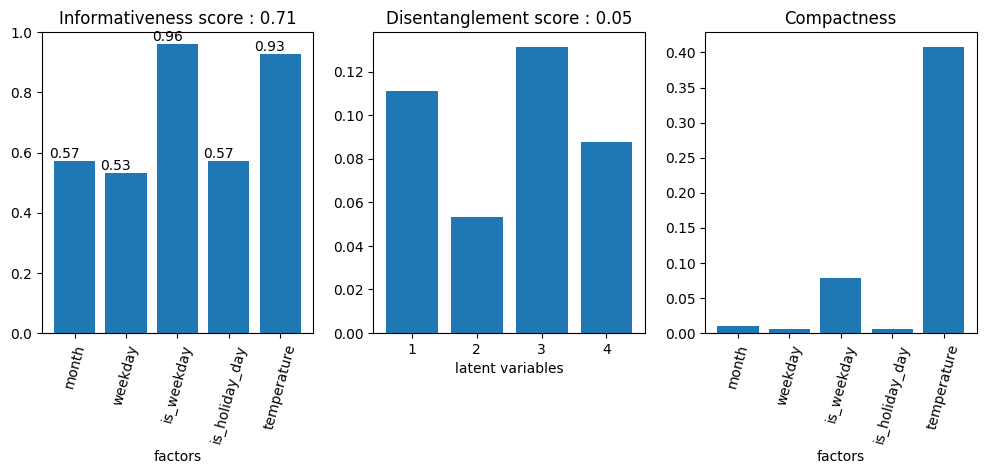

In [105]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc, orthogonalize=True)
display_metrics(model_eval, z_dim, factorDesc)

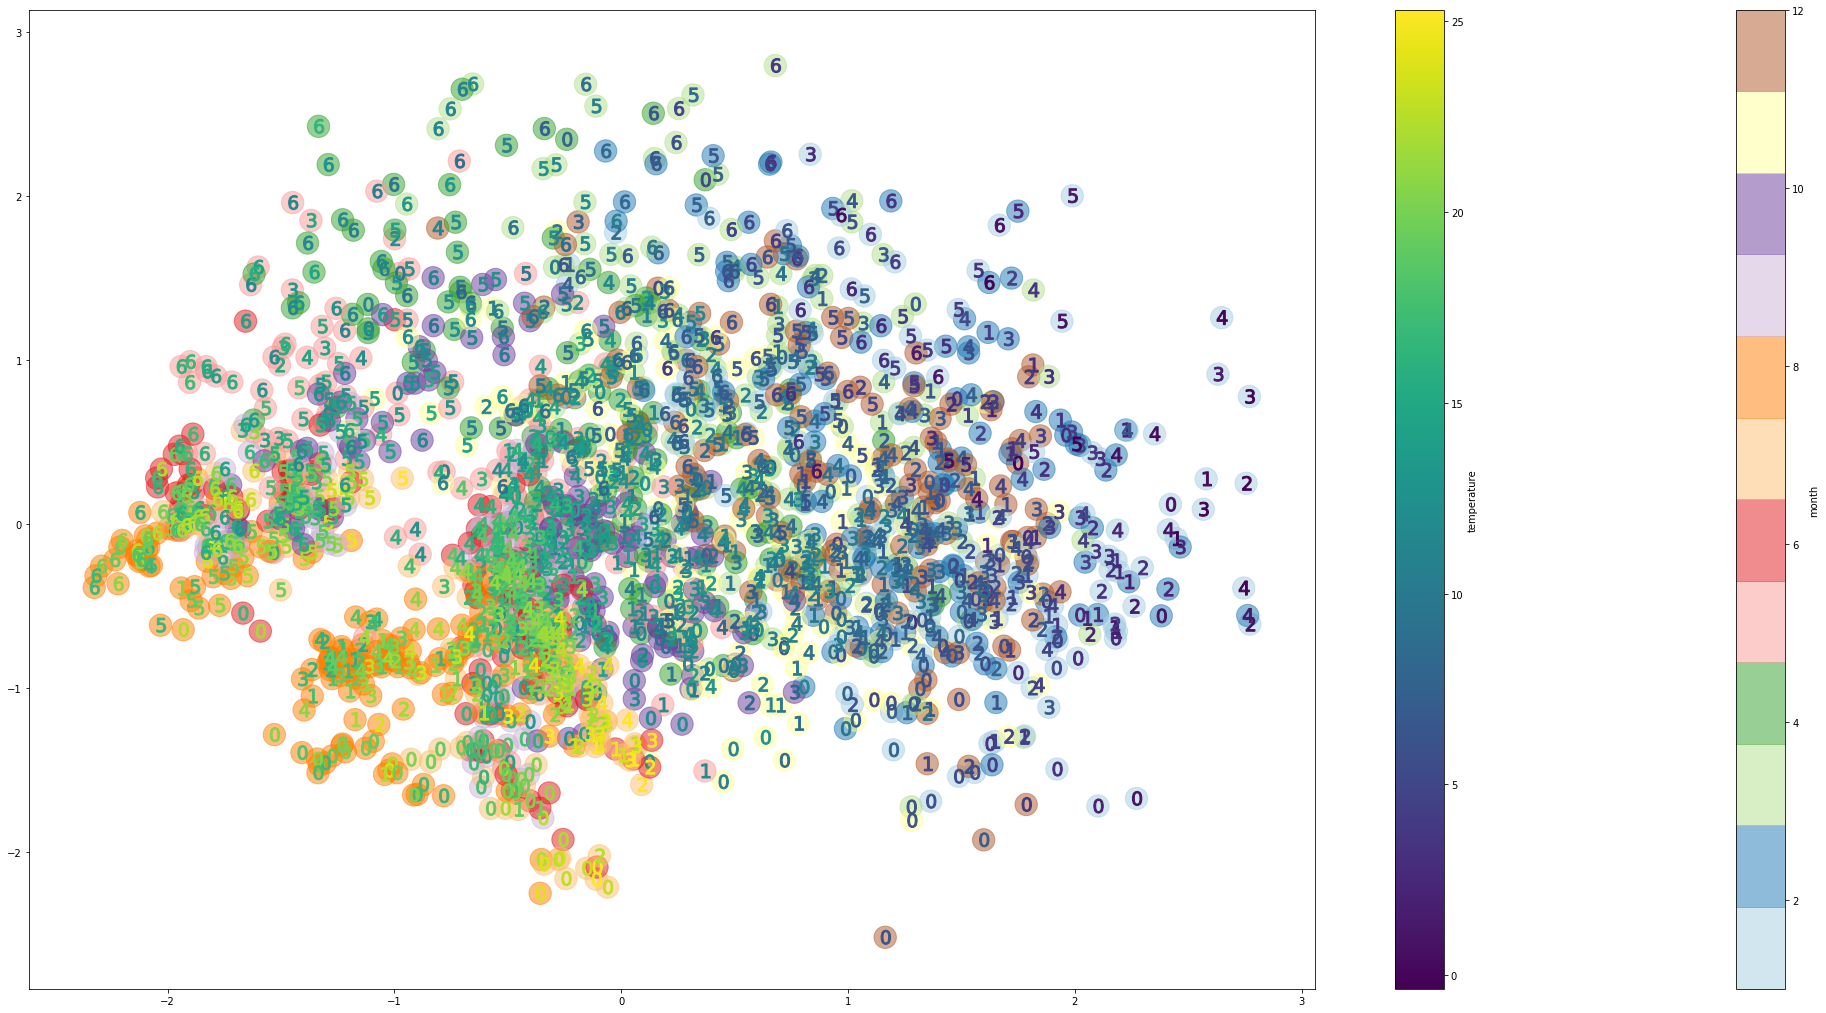

In [106]:
prez_2D(x_encoded)

In [127]:
np.mean(x_encoded,axis=0)

array([ 0.03784512, -0.01415734,  0.00130258,  0.04307379], dtype=float32)

<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 3. Modèle avec LEAP block </b> </font> <hr>
</div>

Dans le modèle LEAP, la sortie de l'encodeur classique est à nouveau projeté dans un nouvel l'espace: celui du statut des écarts, $\tau$ vecteur sparse, vis à vis d'un set de référence. Suite à une multiplication termes à termes de ce vecteur avec la sortie du petit encodeur, le tout est décodé vers l'espace latent qui sera lui-même décodé par le décodeur classique.

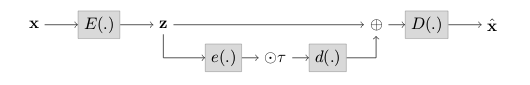

In [171]:
Image(path_main_folder+'/images/leap_vae.png', width=666)

In [111]:
import CVAE.guided_vae_model

importlib.reload(CVAE.guided_vae_model)

<module 'CVAE.guided_vae_model' from '/home/goubetcle/Documents/CVAE/marota_cvae/src/CVAE/guided_vae_model.py'>

On crée ici notre vecteur $\tau$ de référence, par exemple en pointant l'écart de la température moyenne de la journée avec la température décennale de référence, ou en gardant le one-hot encoding de valeurs catégorielles. Le tout est concaténné pour former le vecteur $\tau$.

In [129]:
normal_temperature = np.array([5.0,5.7,8.7,11.1,15.0,18.3,20.8,20.6,17.3,13.5,8.5,5.6]).reshape(-1,1)

from sklearn.preprocessing import StandardScaler
temp_scaler = StandardScaler()
normal_temp = temp_scaler.fit_transform(normal_temperature)

In [134]:
temp = {}
for key in ['train']:
    temp[key]=temp_scaler.transform(np.mean(dataset_cond_all[key]['x'][3],axis=1).reshape(-1, 1))
    
delta_temp={}
for key in ['train']:
    delta_temp[key] = np.zeros(temp[key].shape)
    for m in np.arange(1,13,step=1):
        id_m = np.where(calendar_info['month']==m)
        delta_temp[key][id_m] = temp[key][id_m] - normal_temp[m-1]

In [131]:
list_cond = ['weekday', 'day', 'temperature', 'holiday','month']
dataset_cond_all,_= get_dataset_autoencoder(dict_xconso=dict_xconso, list_cond=list_cond, embedding=True)

weekday (1830, 1)
day (1830, 7)
temperature (1830, 48)
holiday (1830, 1)
month (1830, 12)
6


Le dataset d'entrainement est constitué des mêmes composantes que d'habitude sauf que dataset_leap[key]['x'] doit être composé de 3 parties:

1) les profils;

2) le vecteur $\tau$;

3) les conditions si l'on souhaite faire un CVAE.

In [135]:
dataset_leap= {} 
for key in ['train']:
    dataset_leap[key] = {}
    tau = np.c_[calendar_info['is_holiday_day'].values.reshape(-1,1),
                 dataset_cond_all[key]['x'][5], dataset_cond_all[key]['x'][2],(1-calendar_info['is_weekday']),
                delta_temp[key]] #dataset_all_cond[key]['x'][1][:,8:20],(1-calendar_info[key]['is_weekday']),
    dataset_leap[key]['x']=[dataset[key]['x'][0],tau,dataset[key]['x'][1]]
    dataset_leap[key]['y'] = dataset[key]['y']
    dataset_leap[key]['ds'] = dataset[key]['ds']

In [136]:
input_dims = dataset_leap['train']['x'][0].shape[1]
tau_dims = dataset_leap['train']['x'][1].shape[1]
cond_dims = dataset_leap['train']['x'][2].shape[1]
e_leap_dims = [4*z_dim]

name_model = 'cvae_leap'
log_dir_projector=path_main_folder+"/notebooks/logs/Usecase/"+name_model+"/projector" #pour créer le dossier du projeteur tensorboard
log_dir_model=path_main_folder+"/notebooks/logs/Usecase/"+name_model+"/model" #pour créer le dossier de sauvegarde du modèle
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model

leap_vae = CVAE.guided_vae_model.LEAP_CVAE(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr, e_leap_dims=e_leap_dims,
                                input_dim=input_dims, tau_dims=tau_dims,cond_dims=cond_dims,InfoVAE=InfoVAE,
                                beta=Beta, gamma = Gamma, is_L2_Loss=False,         
                                name=name_model, output=path_out)

InfoVAE :  True
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
tau_true (InputLayer)           (None, 22)           0                                            
__________________________________________________________________________________________________
cond_true (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 6322        x_true[0][0]                     
                                                              

In [138]:
tensorboard = TensorBoard(log_dir="logs/Usecase/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)



--- START TRAINING ---



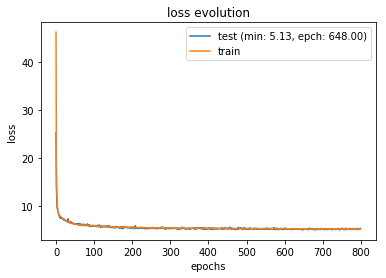

In [139]:
runTraining = False
if runTraining:
    leap_vae.main_train(dataset_leap, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard],validation_split=0.1)
else:
    leap_vae.load_model(os.path.join(path_out, name_model, 'models'))

In [140]:
input_encoder = dataset_leap['train']['x']
x_encoded, variance = leap_vae.encoder.predict(input_encoder)
variance= np.exp(variance)

Mutual Information Gap : 0.13


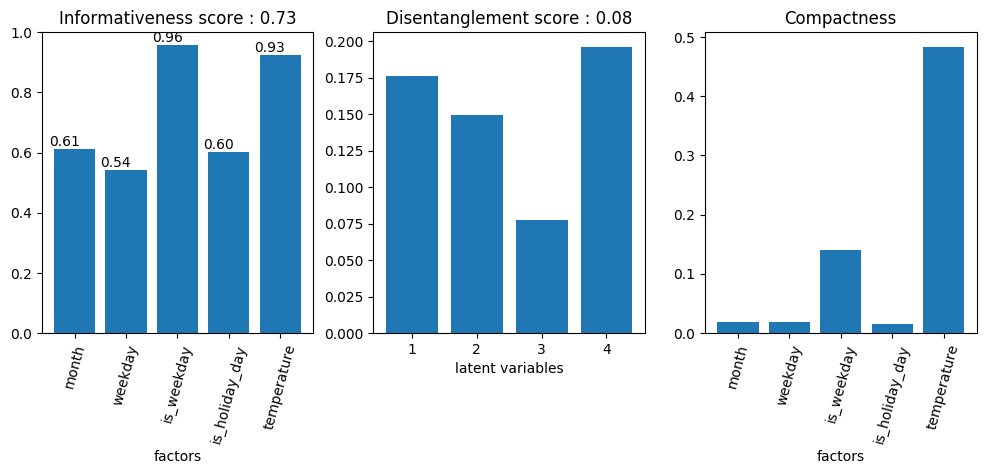

In [141]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc, orthogonalize=True)
display_metrics(model_eval, z_dim, factorDesc)

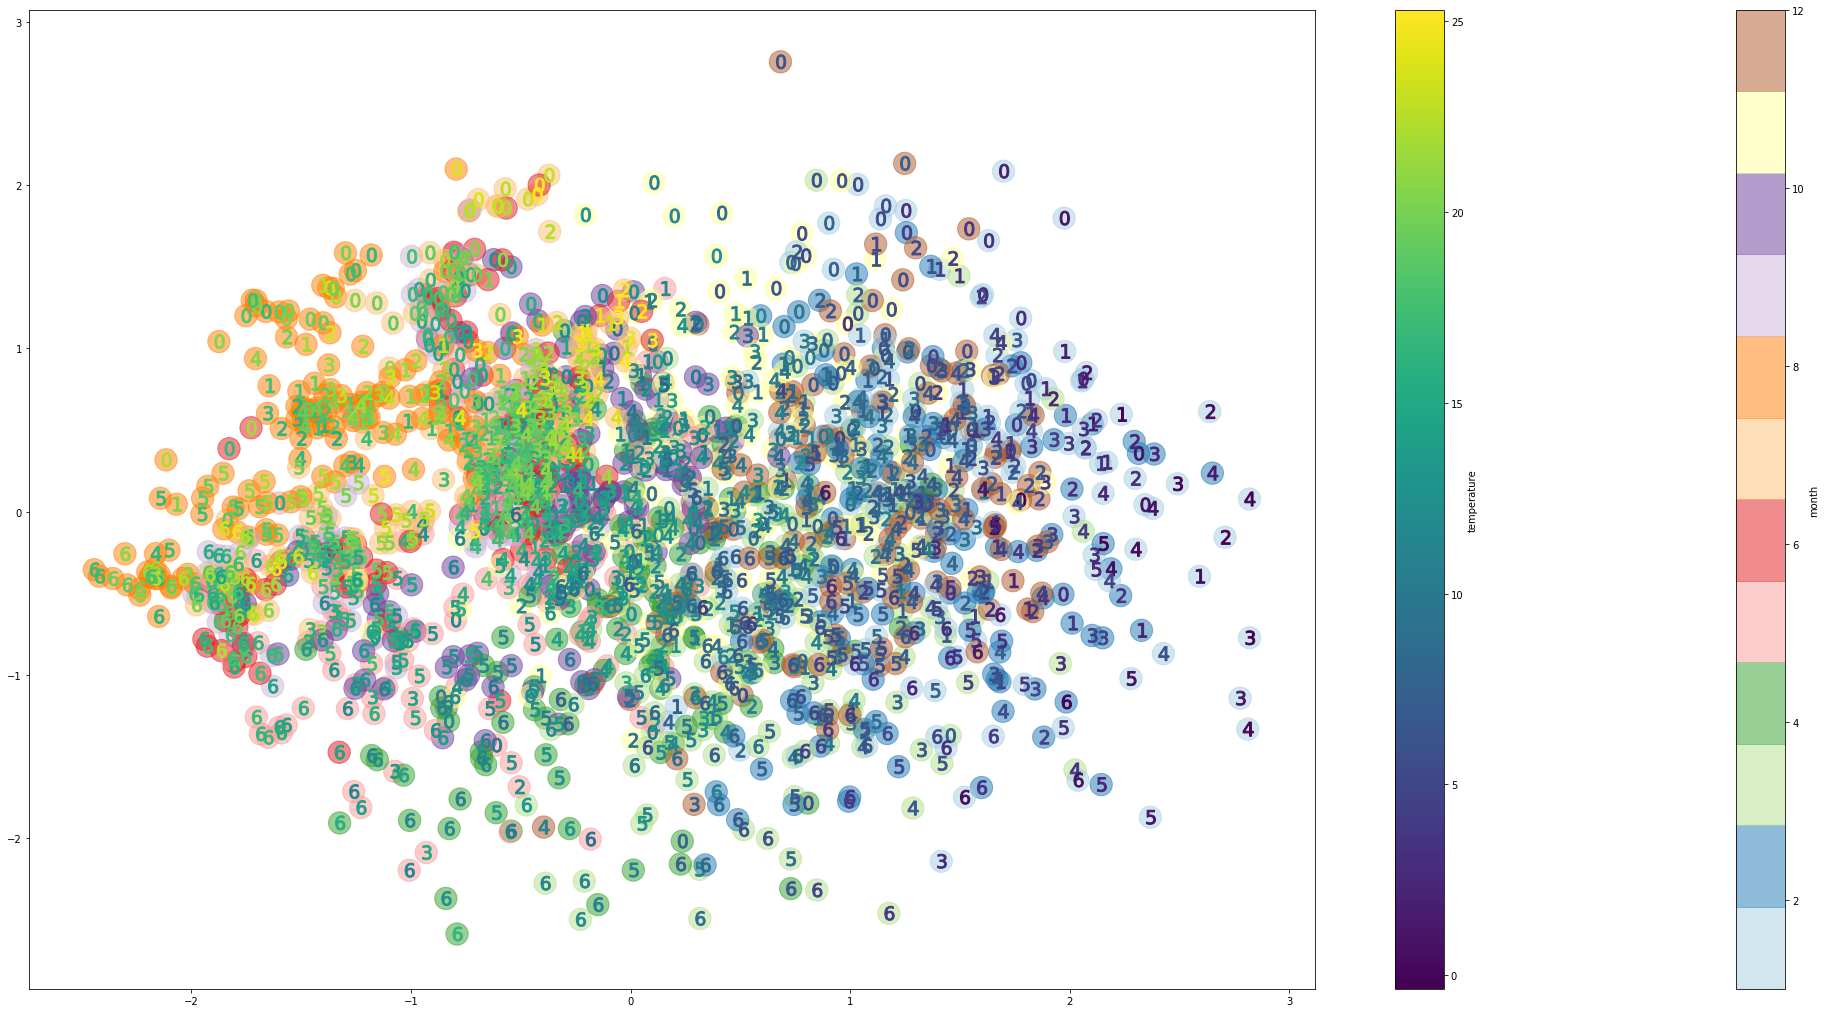

In [142]:
prez_2D(x_encoded)

In [144]:
#calculer l'erreur de reconstruction
x = input_encoder[0]
x_hat =  leap_vae.cvae.predict(input_encoder)[0]
mae_error = np.sum(np.abs((x - x_hat)),axis=1)
mse_error = np.sqrt(np.sum((x - x_hat)**2, axis=1)) 

print(np.mean(mae_error),np.std(mae_error))
print(np.mean(mse_error),np.std(mse_error))

1.897094541032584 0.7696424311098957
0.34372749093791355 0.14290302662579082


<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 4. Modèle avec guidage des conditions </b> </font> <hr>
</div>

En ce qui concerne le guided_vae, il s'agit d'encoder chacune des conditions données en entrée avec chacune leur propre encodeur et le tout sommé avant decodage. 

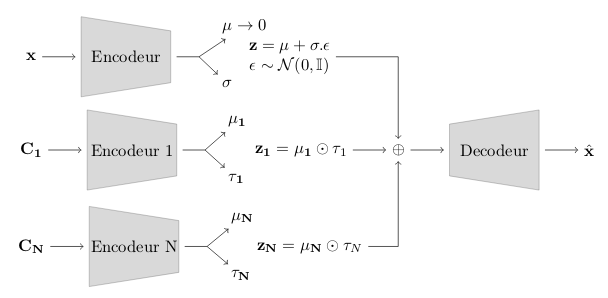

In [172]:
Image(path_main_folder+'/images/guided_vae.png', width=666)

Chacune des conditions est donnée dans une liste à la suite des profils, comme ce qui était fait pour une entrée avec embedding.

In [146]:
list_cond=['day', 'month', 'temperature', 'is_holiday_day']
dataset_guided, _ = get_dataset_autoencoder(dict_xconso=dict_xconso, list_cond=list_cond,embedding=True)

day (1830, 7)
month (1830, 12)
temperature (1830, 48)
is_holiday_day (1830, 1)
5


In [153]:
dataset_guided['train']['x'].append( pd.get_dummies(calendar_info['season']).values)

On donne ici les paramètres qui caractérisent les différents NN encodeurs, à savoir la dimension d'input (liste input\_dims), et les dimensions des couches des encodeurs (liste de listes cond\_dims, de longueur le nombre de conditions après les profils).

In [158]:
input_dims = [dataset['train']['x'][0].shape[1]] + [7,12,48,1,3]
cond_dims = [[14,36,24,12],[12,36, 24,12], [48,36,24,12], [12,36, 24,12], [12,36, 24, 12]]


In [156]:
import CVAE.guided_vae_model
importlib.reload(CVAE.guided_vae_model)

<module 'CVAE.guided_vae_model' from '/home/goubetcle/Documents/CVAE/marota_cvae/src/CVAE/guided_vae_model.py'>

In [159]:
name_model = 'cvae_guided'
log_dir_projector=path_main_folder+"/notebooks/logs/Usecase/"+name_model+"/projector" #pour créer le dossier du projeteur tensorboard
log_dir_model=path_main_folder+"/notebooks/logs/Usecase/"+name_model+"/model" #pour créer le dossier de sauvegarde du modèle
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model

guided_vae = CVAE.guided_vae_model.Guided_VAE(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,#\les paramètres de l'encodeur des profils
                                input_dim=input_dims, cond_dims=cond_dims,InfoVAE=InfoVAE, #les paramètres des autres encodeurs ici
                                beta=Beta, gamma = Gamma, is_L2_Loss=False,   
                                name=name_model, output=path_out)

InfoVAE :  True
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 7)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 12)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 48)           0                                            
______________________________________________________________

In [160]:
tensorboard = TensorBoard(log_dir="logs/Usecase/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)



--- START TRAINING ---



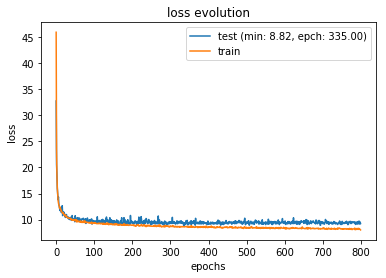

In [161]:
runTraining = False
if runTraining:
    guided_vae.main_train(dataset_guided, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard],validation_split=0.1)
else:
    guided_vae.load_model(os.path.join(path_out, name_model, 'models'))

In [162]:
input_encoder = dataset_guided['train']['x']
x_encoded, log_sigma_train = guided_vae.encoder.predict(input_encoder)
variance_train= np.exp(log_sigma_train)

Mutual Information Gap : 0.22


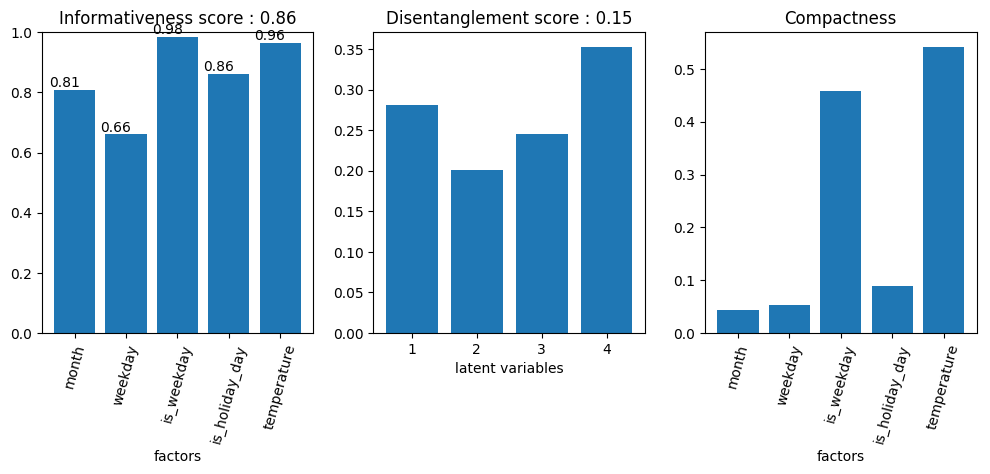

In [163]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc, orthogonalize=True)
display_metrics(model_eval, z_dim, factorDesc)

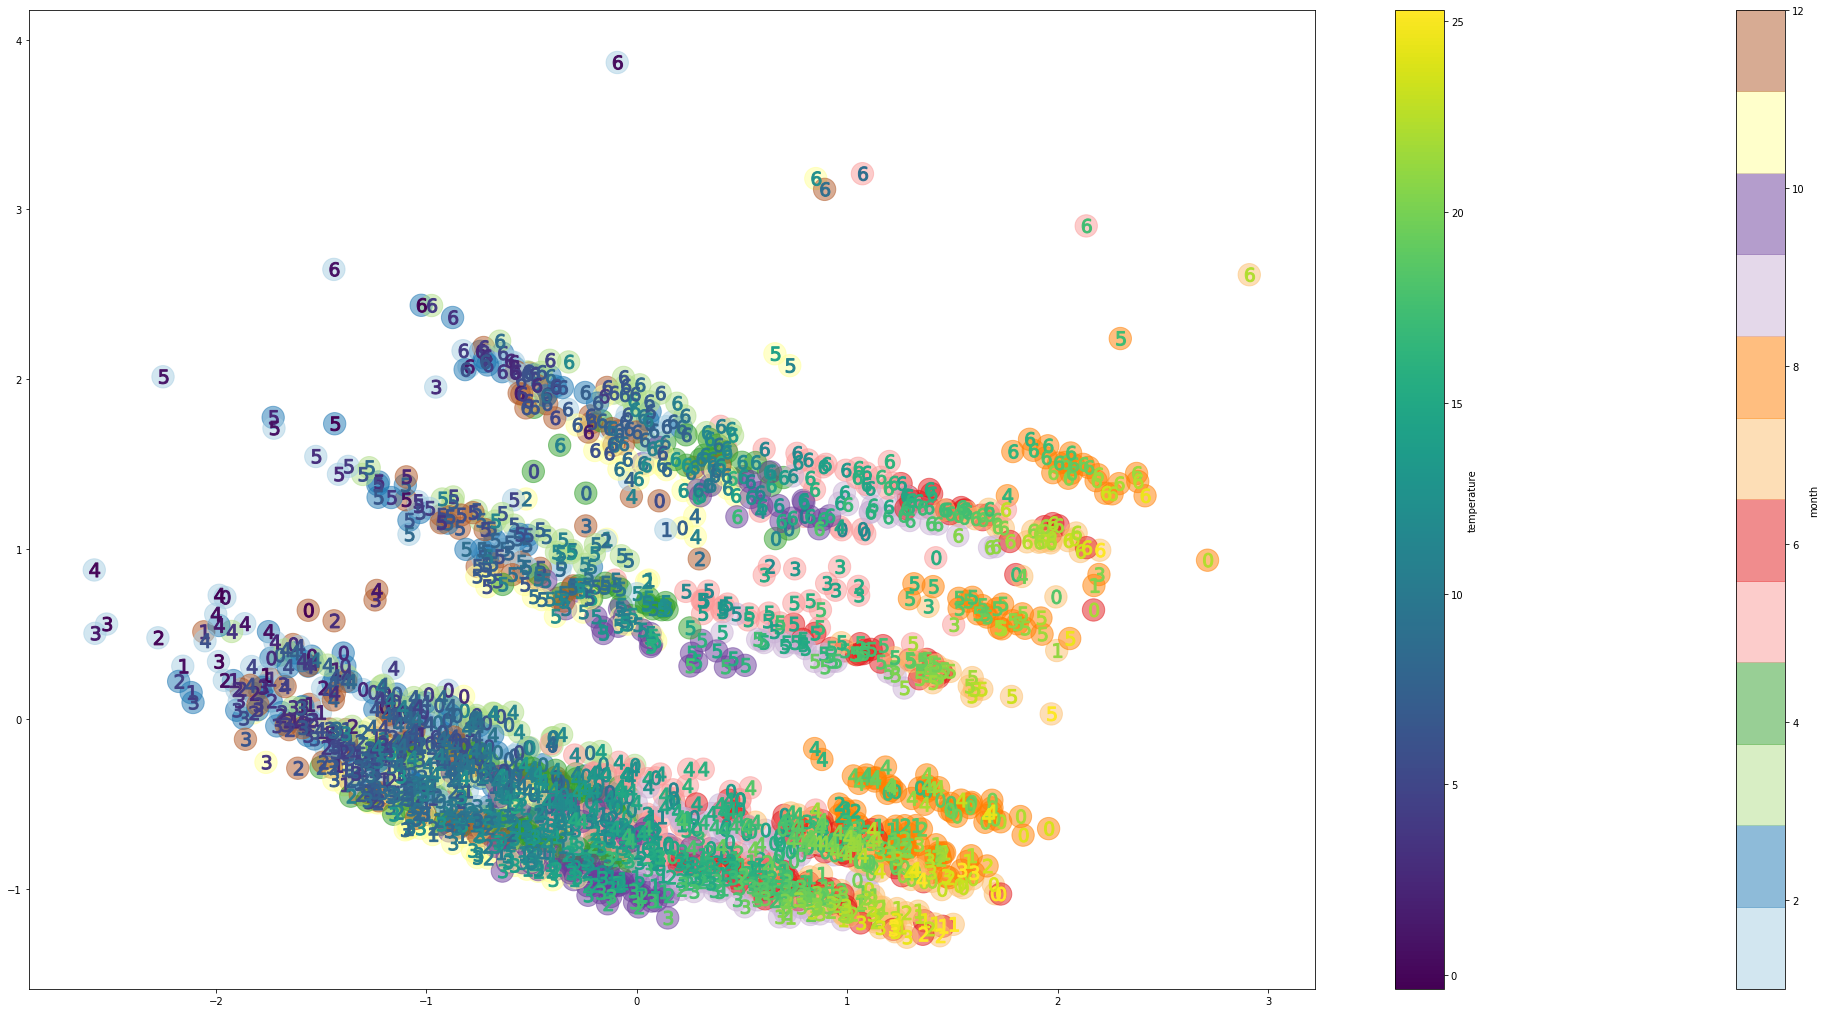

In [164]:
prez_2D(x_encoded)

In [165]:
#calculer l'erreur de reconstruction
x = input_encoder[0]
x_hat =  guided_vae.cvae.predict(input_encoder)[0]
mae_error = np.sum(np.abs((x - x_hat)),axis=1)
mse_error = np.sqrt(np.sum((x - x_hat)**2, axis=1)) 

print(np.mean(mae_error),np.std(mae_error))
print(np.mean(mse_error),np.std(mse_error))

5.296044976511529 4.221709442865936
0.8631172125541603 0.6317791302899046
